<a href="https://colab.research.google.com/github/lucaspn017/qualitative_datas/blob/main/ECommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The following dataset contains several user sessions on an e-commerce platform.
## **Problems**:

> Determine at what point users typically abandon the page.

> Is there a correlation between the user's referral source and the last type of page they accessed?

> To that end, what is the possible causal relationship (if any) between the two variables?

In [1]:
from wordcloud import WordCloud
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("sufya6/e-commerce-customer-journey-click-to-conversion")

print("Path to dataset files:", path)

100%|██████████| 164k/164k [00:00<00:00, 20.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sufya6/e-commerce-customer-journey-click-to-conversion/versions/1


#1: We have to define the data according to its data types.

In [2]:
data = pd.read_csv(path + '/customer_journey.csv')
data.duplicated().sum()
data.isnull().sum()
data.head()

,SessionID,UserID,Timestamp,PageType,DeviceType,Country,ReferralSource,TimeOnPage_seconds,ItemsInCart,Purchased
0,session_0,user_2223,2025-01-20 22:53:34,home,Desktop,India,Social Media,55,0,0
1,session_1,user_2192,2025-02-26 12:57:10,home,Tablet,Germany,Email,99,0,0
2,session_1,user_2192,2025-02-26 12:59:11,product_page,Tablet,Germany,Email,121,0,0
3,session_2,user_1708,2025-06-24 15:40:46,home,Mobile,India,Google,160,0,0
4,session_3,user_2976,2025-06-11 07:21:02,home,Tablet,UK,Google,113,0,0


In [3]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

#2. In which PageType the users commonly stops your navigation at the web?

In [4]:
data = data.sort_values(by='Timestamp')

last_page_per_user = data.groupby('UserID').tail(1)['PageType']

last_page_df = last_page_per_user.to_frame().reset_index()
last_page_df.columns = ['UserID', 'Last PageType']

lastAccess = last_page_df['Last PageType'].value_counts().reset_index()
lastAccess.columns = ['PageType', 'Count']

display(last_page_df)

,UserID,Last PageType
0,3002,product_page
1,2679,product_page
2,9246,confirmation
3,8426,product_page
4,5754,product_page
...,...,...
1867,11870,product_page
1868,4605,confirmation
1869,1706,cart
1870,8120,cart


/tmp/ipython-input-207689384.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lastAccess, x='PageType', y='Count', palette='Blues_r')


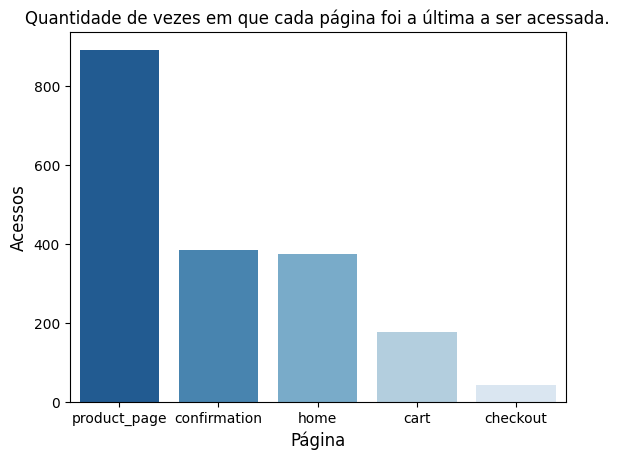

In [5]:
sns.barplot(data=lastAccess, x='PageType', y='Count', palette='Blues_r')
plt.title('Quantidade de vezes em que cada página foi a última a ser acessada.', )
plt.xlabel('Página', fontsize=12)
plt.ylabel('Acessos', fontsize=12)
plt.show()

#3. Let´s verify in which page users tipycally dispends more time.

In [6]:

grouped_by_page = data.groupby(['UserID', 'PageType'])
time_per_page = grouped_by_page['TimeOnPage_seconds'].sum()

expendMoreTime = time_per_page.groupby('PageType').mean()

expendMoreTime = pd.DataFrame(expendMoreTime.sort_values(ascending=False))


/tmp/ipython-input-942659730.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=expendMoreTime, x='PageType', y='TimeOnPage_seconds', palette='Reds_r')


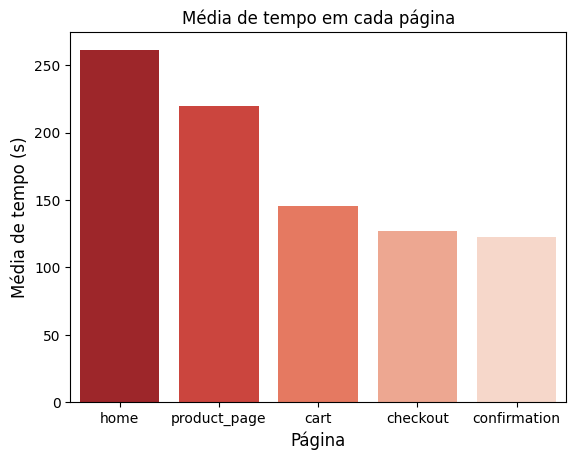

In [7]:
# Usando uma paleta de tons vermelhos
sns.barplot(data=expendMoreTime, x='PageType', y='TimeOnPage_seconds', palette='Reds_r')
plt.title('Média de tempo em cada página')
plt.xlabel('Página', fontsize=12)
plt.ylabel('Média de tempo (s)', fontsize=12)
plt.show()

In [8]:
PageTypeMostTime = time_per_page.groupby('UserID').idxmax()
pageType = PageTypeMostTime.apply(lambda x:x[1])
print(pageType.value_counts())

TimeOnPage_seconds
home            1150
product_page     580
cart              79
checkout          36
confirmation      27
Name: count, dtype: int64


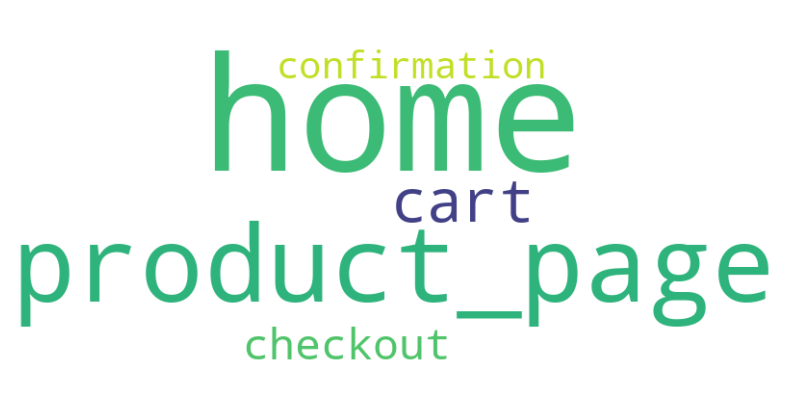

In [9]:
# @title
from wordcloud import WordCloud

# Assuming pageType is a pandas Series where each entry is the PageType
# We need to join all the PageTypes into a single string for the word cloud
pageType = PageTypeMostTime.apply(lambda x:x[1])
text = " ".join(pageType.astype(str))

# Use a different color map and increase max_words for better distinction
nuvem = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

# Observations:

### Users dispends more time in home page.


*   It´s possible that we have a `website structure` in this page not too responsible to `user´s intuition`.
*   In the second position we have the `product page`. Curiously, this is the same page in which the most users commonly finish the `website landing`.


>> There are at least two possibilities: The product page is not very responsive to user needs, or we need to apply more customer retention techniques.

#4. Now, let´s verify if there are some correlation between the referral source and the last page accessed.

In [10]:
SourceAccess = data.groupby('UserID').tail(1)['ReferralSource']
SourceAccess = SourceAccess.to_frame().reset_index()
SourceAccess.columns = ['UserID', 'Last Referral Source']

LastSourceAccess =  pd.merge(SourceAccess, last_page_df, on='UserID')
LastSourceAccess = LastSourceAccess.groupby('Last Referral Source')['Last PageType'].value_counts().unstack(fill_value=0)

display(LastSourceAccess)

Last PageType,cart,checkout,confirmation,home,product_page
Last Referral Source,,,,,
Direct,42,7,97,102,228
Email,46,14,89,86,237
Google,50,11,109,94,218
Social Media,40,12,90,92,208


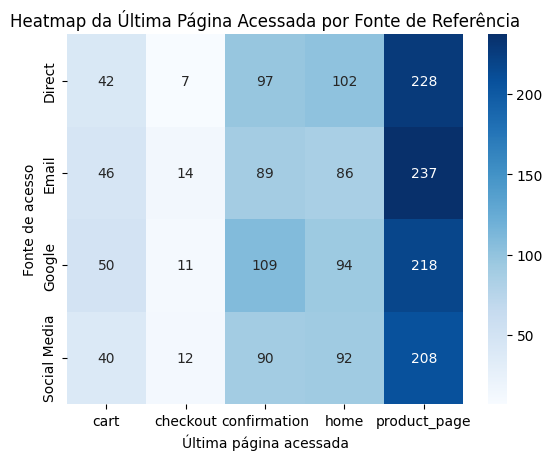

In [11]:
sns.heatmap(data = LastSourceAccess, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap da Última Página Acessada por Fonte de Referência')
plt.xlabel('Última página acessada')
plt.ylabel('Fonte de acesso')
plt.show()

Based on the heatmap generated, we can observe the number of times each page type was the last page accessed, separated by referral source:

* The `product_page` column presents the highest values ​​across all rows, indicating that, regardless of the referral source, the product page is the most common place users end their browsing experience.
* The `home` and `confirmation` columns also show relevant counts for all referral sources. The high count for `confirmation` is a good sign, as it suggests that many users complete their purchase.
* Note that we have a high conversion rate when users arrive on the page through Google, meaning they have a `specific goal`. However, from other referral sources, primarily `email` or `social media`, we have slightly `fewer users` ending up on this page.

This initial analysis shows that users prefer to quickly return to the previous site if the shopping site isn't objective, especially when the previous site is a social network. Given that, in a scenario where they're specifically searching for that product, the rate of access to the confirmation page is higher.